In [1]:
import torch
from torch.nn import CosineSimilarity, MSELoss
from torch.utils.data import DataLoader
import json
import pandas as pd
from sapiens.cnn import ResCNN, ResCNNConfig
from sapiens.data import Dataset
from typing import List
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR

In [331]:
config = ResCNNConfig(
    tokenizer = "michiyasunaga/BioLinkBERT-large",
    vocab_size =  28895,
    aggregate = "attentionpool",
    in_dim = 1024,
    block_dim = 256,
    out_dim = 256,
    dropout = 0.15,
    depth = 2,
    max_length=100
)
model = ResCNN(config)

In [387]:
model.load_ckpt("sapiens/resources/checkpoints/99d2852/run3/checkpoint_e4_msigdb_biosses.pt")

In [363]:
model.freeze_embeds()
for p in model.parameters(): p.requires_grad = False
for p in model.agg.parameters(): p.requires_grad = True

In [364]:
class CosineSimilarityLoss:
    def __init__(self):
        self.sim = CosineSimilarity()
        self.error = MSELoss()
        
    def __call__(self, source: torch.Tensor, target: torch.Tensor, score: torch.Tensor) -> torch.Tensor:
        y_pred = self.sim(source, target)
        loss = self.error(y_pred, score)
        return loss
    
def sentsim_collate(batch: list):
    '''collates sentence similarity data for dataloader'''
    sent1s = [[i[0][0]] for i in batch]
    sent2s = [[i[0][1]] for i in batch]
    scores = torch.tensor([i[1] for i in batch])
    return sent1s, sent2s, scores

In [365]:
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
loader = DataLoader(dataset, batch_size = 16, pin_memory = True, collate_fn = sentsim_collate)
scheduler = LinearLR(optimizer, start_factor = 1.0, end_factor = 0.1, total_iters = 5 * len(loader))

In [366]:
dataset = Dataset("sapiens/datasets/MsigDB/c7_scored.json")
biosses = Dataset("sapiens/datasets/BIOSSES/train_biosses.json")

valset = Dataset("sapiens/datasets/BIOSSES/val_biosses.json")
valset.data.extend(dataset.data[34:])
dataset.data = dataset.data[:34] + biosses.data
valloader = DataLoader(valset, batch_size=20, collate_fn = sentsim_collate)

In [367]:
loss_func = CosineSimilarityLoss()

sent1, sent2, scores = list(loader)[0]
loss = loss_func(model(sent1), model(sent2), scores)
print("START:", loss.item())


for e in range(5):
    print(e)
    model.train()
    for batchidx, (sent1, sent2, scores) in enumerate(loader):
        optimizer.zero_grad()
        embeds1 = model(sent1)
        embeds2 = model(sent2)
        loss = loss_func(embeds1, embeds2, scores)
        loss.backward()
        optimizer.step()
        scheduler.step()
        print("train:", f"{loss.item():.3f}", end=", ")
        
        model.eval()
        for (v1, v2, vscores) in valloader:
            valemb1 = model(v1)
            valemb2 = model(v2)
            val_loss = loss_func(valemb1, valemb2, vscores)
            print("val:", f"{val_loss.item():.3f}")

START: 0.055784761905670166
0
train: 0.067, val: 0.098
train: 0.054, val: 0.098
train: 0.053, val: 0.098
train: 0.112, val: 0.098
train: 0.072, val: 0.098
train: 0.079, val: 0.098
train: 0.056, val: 0.098
1
train: 0.071, val: 0.098
train: 0.054, val: 0.098
train: 0.053, val: 0.098
train: 0.112, val: 0.098
train: 0.072, val: 0.098
train: 0.079, val: 0.098
train: 0.056, val: 0.098
2
train: 0.064, val: 0.098
train: 0.055, val: 0.098
train: 0.053, val: 0.098
train: 0.111, val: 0.098
train: 0.071, val: 0.098
train: 0.079, val: 0.098
train: 0.056, val: 0.098
3
train: 0.064, val: 0.098
train: 0.055, val: 0.098
train: 0.053, val: 0.098
train: 0.111, val: 0.098
train: 0.071, val: 0.098
train: 0.079, val: 0.098
train: 0.056, val: 0.098
4
train: 0.073, val: 0.098
train: 0.055, val: 0.098
train: 0.053, val: 0.098
train: 0.111, val: 0.098
train: 0.071, val: 0.098
train: 0.078, val: 0.098
train: 0.056, val: 0.098
5
train: 0.058, val: 0.098
train: 0.055, val: 0.098
train: 0.053, val: 0.098
train: 0.1

In [338]:
torch.save(
{"comment": "pretrained on MedMen+CRAFT contrastive, then train on msigdb title/desc",
"model_state_dict": model.state_dict()},
    "sapiens/resources/checkpoints/99d2852/run3/checkpoint_e4_msigdb_biosses.pt"
)

In [339]:
from sapiens.index import OntologyIndex, BuildConfig
from random import randint
from sapiens_api.utils import preprocess

In [340]:
model.eval()
GO_index = OntologyIndex(ontopath="sapiens/resources/ontologies/GO/go_BP_subset.json", distance_measure="cosine")
GO_index.infer_dataset(model, True)

In [368]:
c7 = json.load(open("sapiens/resources/msigdb/msigdb_C7.json", "r"))
i = randint(0, len(c7))
test_case = list(c7.keys())[i]
test_case = " ".join(test_case.lower().split("_")[1:-2])
test_case_desc =  c7[list(c7.keys())[i]]["DESCRIPTION_BRIEF"]
print(test_case_desc)
test_case_desc = preprocess(test_case_desc)
test_case_desc

Genes up-regulated in comparison of dendritic cells (DC) stimulated with CpG DNA (TLR9 agonist) at 2 h versus DC cells stimulated with Gardiquimod (TLR7 agonist) at 2 h.


'dendritic cells (DC) stimulated with CpG DNA (TLR9 agonist)  versus DC cells stimulated with Gardiquimod (TLR7 agonist) .'

In [389]:
%%time
txt_input = 'dendritic cells (DC) stimulated with CpG DNA (TLR9 agonist) versus DC cells stimulated with Gardiquimod (TLR7 agonist) .'
embedding = model([txt_input]).detach().squeeze().numpy()
topk, distances = GO_index.search(embedding, 35)
topk

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.39 ms


[[GO:0002749|antigen processing and presentation initiated by TLR mediated phagocytosis of antigen,
  GO:1904241|activation of Cdc48p-Npl4p-Ufd1p AAA ATPase complex formation,
  GO:1904241|activation of Cdc48p-Npl4p-Ufd1p AAA ATPase complex assembly,
  GO:0044546|NLRP3 inflammasome activation,
  GO:1904241|activation of VCP-NPL4-UFD1 AAA ATPase complex assembly,
  GO:1904241|activation of VCP-NPL4-UFD1 AAA ATPase complex formation,
  GO:0002291|T lymphocyte activation via T cell receptor contact with antigen bound to MHC molecule on antigen presenting cell,
  GO:1900227|activation of NLRP3 inflammasome complex assembly,
  GO:1901544|activation of ent-pimara-8(14),15-diene anabolism,
  GO:0002291|T cell activation via T cell receptor contact with antigen bound to MHC molecule on antigen presenting cell,
  GO:1900700|activation of o-orsellinic acid anabolism,
  GO:1904241|activation of p97-Ufd1-Npl4 complex assembly,
  GO:0002753|cytoplasmic caspase-recruiting domain (CARD) helicase sign

In [420]:
response = json.load(open("test.json"))
data = [i[0]["text"] for i in response["results"]["GO"]]

sim = CosineSimilarity()
ranks = []
for d in data:
    ranks.append((sim(torch.tensor(embedding), model([d])).detach()[0].item(), d))

In [422]:
ranks.sort(key=lambda x: x[0])

In [423]:
ranks

[(0.3933355212211609, 'DNA recombination'),
 (0.4283619821071625, 'RNA-mediated DNA recombination'),
 (0.441979318857193, 'DNA ligation involved in DNA recombination'),
 (0.4475785195827484, 'DNA ligation during DNA recombination'),
 (0.4523884952068329, 'reciprocal DNA recombination'),
 (0.5129498839378357, 'duplex DNA melting'),
 (0.521191418170929, 'TLR6 signaling pathway'),
 (0.5217236876487732, 'TLR1 signaling pathway'),
 (0.5296211838722229, 'activation of macrophage activation'),
 (0.5316084027290344, 'activation of meiotic recombination'),
 (0.5323025584220886, 'TLR7 signaling pathway'),
 (0.5385515093803406, 'TLR8 signaling pathway'),
 (0.5699447989463806, 'activation of homologous recombinational repair'),
 (0.5801493525505066, 'activation of DNA recombination'),
 (0.586395263671875, 'inflammasome complex assembly'),
 (0.6042332649230957, 'MyD88-dependent TLR2 signaling pathway'),
 (0.6097202301025391, 'TLR2:TLR6 signaling pathway'),
 (0.6099355220794678, 'TLR2:TLR1 signaling

In [139]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_ner_craft_md")

In [ ]:
matcher = Matcher(nlp.vocab)
# Add match ID "HelloWorld" with no callback and one pattern
pattern = [{"LIKE_NUM": True}]
matcher.add("HelloWorld", [pattern])

In [385]:
X = model.bert_base([test_case_desc])
X2 = torch.zeros(size=X.shape)
test = model.debug(X)
test_base = model.debug(torch.zeros(size=X2.shape))
toks = model.bert_base([test_case_desc],return_option="toks_only").tokens()

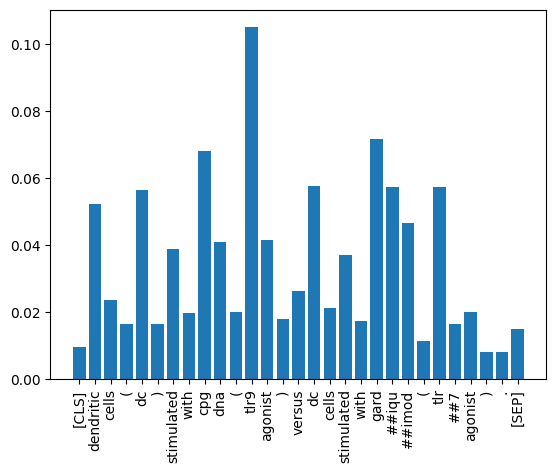

In [386]:
import matplotlib.pyplot as plt

def attn(X):
    return torch.nn.functional.softmax(model.agg.Q(X.mT), dim=1).flatten()

sums = torch.abs(attn(test[1])).detach()
plt.bar(range(len(toks)), sums)
plt.xticks(range(len(toks)), labels=toks, rotation = 90)
plt.show()